# 算法库导入

In [49]:
import numpy as np
import pandas as pd

from tensorflow.keras.utils import normalize

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tqdm import tqdm

# 加载数据

In [26]:
df = pd.read_csv('data/us-101mo.csv')
df

Vehicle_ID  Frame_ID  Total_Frames  Local_X   Local_Y  Lane_ID  \
0                 2       373           437    8.139  1645.564        1   
1                 2       374           437    8.142  1651.103        1   
2                 2       375           437    8.071  1656.655        1   
3                 2       376           437    7.985  1662.194        1   
4                 2       377           437    7.901  1667.701        1   
...             ...       ...           ...      ...       ...      ...   
1022934        3109      7188           510   57.416  2102.072        5   
1022935        3109      7189           510   57.398  2107.121        5   
1022936        3109      7190           510   57.411  2112.135        5   
1022937        3109      7191           510   57.407  2117.636        5   
1022938        3109      7192           510   57.403  2122.635        5   

         v_Vel  v_Acc  
0        55.23   2.11  
1        55.35   1.01  
2        55.35  -1.02  
3        55.23  -2.14  
4        55.07  -1.15  
...        ...    ...  
1022934  50.40   4.95  
1022935  51.03   7.74  
1022936  51.03   0.00  
1022937  51.03   0.00  
1022938  51.03   0.00  

[1022939 rows x 8 columns]

# 数据处理

## 速度插值

In [27]:
# X = []
# Y = []

# X_v = []
# Y_v = []

# for i in range(len(data)):
#     if i == 0:
#         X.append('none')
#         X_v.append('none')
#         Y.append('none')
#         Y_v.append('none')
#     else:
#         if data.Vehicle_ID[i] == data.Vehicle_ID[i-1]:
#             X.append(data.Local_X[i]-data.Local_X[i-1])
#             X_v.append((data.Local_X[i]-data.Local_X[i-1])/0.1)
#             Y.append(data.Local_Y[i]-data.Local_Y[i-1])
#             Y_v.append((data.Local_Y[i]-data.Local_Y[i-1])/0.1)
#         else:
#             X.append('none')
#             X_v.append('none')
#             Y.append('none')
#             Y_v.append('none')
# X

In [28]:
# dic = {'X': X, 'X_v': X_v, 'Y': Y, 'Y_v': Y_v}
# df = pd.DataFrame(data=dic)
# df

In [29]:
# # 合并数据集

# df = pd.concat([data, df], axis=1)
# df

## 特征提取

In [30]:
# # none数据清洗

# df = df[df["X_v"] != 'none']
# df

In [31]:
# 车辆数统计

Vehicle_ID = df['Vehicle_ID']
Vehicle_ID_LIST = []
for i in range(len(df)):
    if Vehicle_ID[i] not in Vehicle_ID_LIST:
        Vehicle_ID_LIST.append(Vehicle_ID[i])
len(Vehicle_ID_LIST)

2808

## 标准化

In [32]:
# 定义MAX-MIN标准化函数
def normalize(X):

    norm = (X-min(X))/(max(X)-min(X))

    return(norm)



LX = normalize(df["Local_X"])
LY = normalize(df["Local_Y"])

print(LX,'\n\n------------\n\n',len(LX))

0          0.069344
1          0.069390
2          0.068306
3          0.066992
4          0.065710
             ...   
1022934    0.821837
1022935    0.821562
1022936    0.821761
1022937    0.821700
1022938    0.821639
Name: Local_X, Length: 1022939, dtype: float64 

------------

 1022939


In [33]:
# 合并X，Y位置

arrtrain = []
traindata = []

for i in range(len(df)):
    if i == 0:
        arrtrain.append([LX.iloc[i], LY.iloc[i]])
    else:
        if i == len(df) - 1:
            arrtrain.append([LX.iloc[i], LY.iloc[i]])
            traindata.append(arrtrain)
        else:
            if df['Vehicle_ID'].iloc[i] == df['Vehicle_ID'].iloc[i-1]:
                arrtrain.append([LX.iloc[i], LY.iloc[i]])
            else:
                traindata.append(arrtrain)
                arrtrain = []
                arrtrain.append([LX.iloc[i], LY.iloc[i]])

In [34]:
# 长轨迹筛选

traindata2 = []
index = pd.DataFrame()

for i in range(len(traindata)):
    if len(traindata[i]) > 95:
        index = index.append({'i': i, 'len': len(traindata[i])},ignore_index=True)
        traindata2.append(traindata[i])

print(index)
len(traindata2)

           i    len
0        0.0  336.0
1        1.0  254.0
2        2.0  360.0
3        3.0  325.0
4        4.0  370.0
...      ...    ...
2693  2800.0  102.0
2694  2802.0  106.0
2695  2804.0  106.0
2696  2805.0  102.0
2697  2807.0  113.0

[2698 rows x 2 columns]


2698

In [35]:
# 建立输入输出集
pre_in = []
pre_out = []

Input = []
Output = []

# 训练集输入输出筛选
for i in tqdm(range(len(traindata2))):
    for j in range(len(traindata2[i])):
        if j % 5 == 0:
            if len(pre_in) < 10:
                pre_in.append(traindata2[i][j])
                pre_out.append(traindata2[i][j+45])
            else:
                Input.append(pre_in)
                Output.append(pre_out)
                pre_in = []
                pre_out = []
                break
        else:
            continue

print(len(Input))

100%|███████████████████████████████████████████████████████████████████████████| 2698/2698 [00:00<00:00, 55765.59it/s]

2698


In [36]:
volume = []

df_dup = df.drop_duplicates(subset=['Vehicle_ID'], keep='first')
df_dup=df_dup['Vehicle_ID']

for i in range(len(index)):
    ivolume = []
    a = int(index['i'].iloc[i])
#     print('a: ',a)
    b = df_dup.iloc[a]
#     print('b: ',b)
    df_car = df[df['Vehicle_ID'] == b]
    for j in range(len(df_car)):
        ivolume.append(df_car['Lane_ID'].iloc[j])
#         print(i, ': ', ivolume)
    volume.append(ivolume)
#     print(i,': ',volume)
volume    

[[1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,


In [37]:
at_lane = []
lane = []
np.shape(volume)
for i in range(len(volume)):
    for j in range(0, 100, 5):
        at_lane.append(volume[i][j])
    lane.append(at_lane)
    at_lane = []
lane

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5],
 [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

## 异常变道数据清洗

In [38]:
lane_state = []
for i in range(len(lane)):
    for j in range(1,10):
        if lane[i][j] > lane[i][j-1]:
            if abs(lane[i][j]-lane[i][j-1])>=2:
                Input.pop(i)
                Output.pop(i)
                break
            else:
                lane_state.append([1, 0, 0])
                break
        elif lane[i][j] < lane[i][j-1]:
            if abs(lane[i][j]-lane[i][j-1])>=2:
                Input.pop(i)
                Output.pop(i)
                break
            else:            
                lane_state.append([0, 0, 1])
                break
        elif j == 9:
            lane_state.append([0, 1, 0])
            break
len(lane_state)

2678

## 异常坐标位置清洗

In [39]:
# 0是横向，1是纵向
mark = []
for i in range(len(Input)):
    for j in range(1, 10):
        if abs(Input[i][j][0]-Input[i][j-1][0]) >= 0.3 or abs(Output[i][j][0]-Output[i][j-1][0]) >= 0.3 or abs(Input[i][j][1]-Input[i][j-1][1]) >= 0.3 or abs(Output[i][j][1] - Output[i][j-1][1]) >= 0.3 or Input[i][j][1]-Input[i][j-1][1] < -0.01 or Output[i][j][1] - Output[i][j-1][1] < -0.01:
            mark.append(i)
            break
print(len(mark), mark)
for k in range(len(mark)):
    Input.pop(mark[k]-k)
    Output.pop(mark[k]-k)
    lane_state.pop(mark[k]-k)
len(Input)

922 [0, 3, 6, 7, 8, 10, 11, 18, 19, 20, 21, 23, 24, 25, 29, 30, 32, 35, 36, 37, 38, 41, 42, 45, 47, 48, 49, 52, 53, 54, 61, 62, 65, 74, 77, 81, 86, 89, 91, 93, 94, 95, 96, 101, 102, 108, 111, 112, 118, 120, 123, 125, 126, 129, 131, 132, 137, 138, 142, 143, 144, 145, 146, 147, 148, 149, 152, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 176, 179, 182, 185, 187, 188, 189, 191, 193, 194, 196, 199, 203, 204, 205, 207, 211, 213, 214, 215, 217, 218, 220, 222, 223, 224, 229, 230, 231, 232, 237, 239, 240, 242, 244, 245, 262, 267, 268, 270, 271, 272, 275, 279, 282, 287, 288, 290, 292, 294, 297, 298, 299, 300, 301, 309, 311, 318, 319, 320, 331, 333, 334, 336, 338, 339, 340, 344, 350, 351, 352, 355, 357, 358, 360, 361, 362, 365, 366, 367, 369, 370, 372, 374, 379, 380, 384, 385, 389, 390, 393, 397, 398, 403, 404, 406, 407, 408, 409, 411, 412, 413, 416, 417, 420, 421, 424, 425, 427, 428, 431, 432, 435, 436, 437, 439, 441, 442, 443, 448, 449, 450, 452, 453, 456, 457

1756

In [40]:
Input = np.array(Input)
Output = np.array(Output)


print(Input.shape,Output.shape,len(lane_state))
# print(Input,'\n\n\n------------分割线-----------\n\n\n',Output)

(1756, 10, 2) (1756, 10, 2) 1756


## 训练集测试集划分

In [41]:
In_train, In_test, Out_train, Out_test = train_test_split(
    Input, Output, test_size=0.30, random_state=43)
In_lanetrain, In_lanetest, Out_lanetrain, Out_lanetest = train_test_split(
    Input, lane_state, test_size=0.30, random_state=43)

print(In_train)
print(Out_lanetest)

[[[0.56130412 0.0374871 ]
  [0.56893945 0.08548201]
  [0.56817592 0.13196066]
  ...
  [0.57686493 0.35156788]
  [0.56486218 0.39628755]
  [0.55823471 0.43977208]]

 [[0.22568527 0.07053449]
  [0.2260365  0.08942858]
  [0.20798656 0.11024451]
  ...
  [0.1101779  0.21968096]
  [0.10370314 0.24201007]
  [0.10428342 0.264565  ]]

 [[0.77666641 0.06717629]
  [0.77520043 0.0814494 ]
  [0.77538368 0.10214857]
  ...
  [0.77269604 0.18653064]
  [0.76950447 0.20718833]
  [0.76738184 0.22101287]]

 ...

 [[0.05413453 0.14290169]
  [0.05288234 0.16612182]
  [0.04933954 0.1891622 ]
  ...
  [0.03913873 0.31032623]
  [0.04039093 0.33721027]
  [0.0416584  0.3640943 ]]

 [[0.76828281 0.00969054]
  [0.76794686 0.05459917]
  [0.768237   0.10058776]
  ...
  [0.75568451 0.33026651]
  [0.7602199  0.3768573 ]
  [0.76509124 0.42350801]]

 [[0.08459953 0.08563256]
  [0.08218676 0.12044815]
  [0.07687257 0.15499183]
  ...
  [0.07281057 0.34224449]
  [0.0718027  0.38069942]
  [0.07073376 0.4203572 ]]]
[[0, 1, 0]

In [42]:
np.save('data/Intrain2',In_train)
np.save('data/Outtrain2',Out_train)
np.save('data/Intest2',In_test)
np.save('data/Outtest2',Out_test)
np.save('data/Outlanetrain2',Out_lanetrain)
np.save('data/Outlanetest2',Out_lanetest)

# 可视化

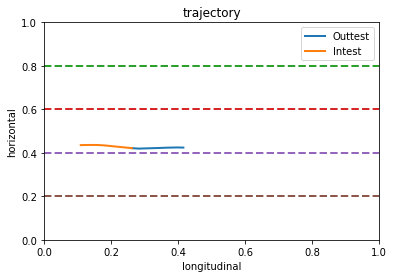

In [50]:
i=4
aIntest = In_test[i].swapaxes(0, 1)
aOuttest = Out_test[i].swapaxes(0, 1)

plt.plot(aOuttest[1], aOuttest[0], lw=2, label="Outtest")
plt.plot(aIntest[1], aIntest[0], lw=2, label="Intest")

plt.plot(np.linspace(0, 1, 2), [0.8, 0.8], lw=2, linestyle='--')
plt.plot(np.linspace(0, 1, 2), [0.6, 0.6], lw=2, linestyle='--')
plt.plot(np.linspace(0, 1, 2), [0.4, 0.4], lw=2, linestyle='--')
plt.plot(np.linspace(0, 1, 2), [0.2, 0.2], lw=2, linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('trajectory')
plt.ylabel('horizontal')
plt.xlabel('longitudinal')
plt.legend()
plt.show()

# 数据增强

In [51]:
import numpy as np
import pandas as pd

## 导入数据

In [52]:
Intrain = np.load('data/Intrain2.npy')
Outtrain = np.load('data/Outtrain2.npy')
Outlanetrain = np.load('data/Outlanetrain2.npy')

Intest = np.load('data/Intest2.npy')
Outtest = np.load('data/Outtest2.npy')
Outlanetest = np.load('data/Outlanetest2.npy')


print(Outlanetrain.shape)
print(Outtest.shape)

(1229, 3)
(527, 10, 2)


## 训练集数据提取

In [53]:
dic = {}

for i in range(Outlanetrain.shape[0]):
    if list(Outlanetrain[i]) == [1, 0, 0]:
        dic[i] = [1, 0, 0]
    elif list(Outlanetrain[i]) == [0, 0, 1]:
        dic[i] = [0, 0, 1]
    else:
        continue

print(len(dic), '\n\n', dic)

newIntrain = []
newOuttrain = []
for i in dic:
    newIntrain.append(Intrain[i])
    newOuttrain.append(Outtrain[i])

newIntrain = np.array(newIntrain)
newOuttrain = np.array(newOuttrain)
newOutlanetrain = np.array(list(dic.values()))

38 

 {1: [0, 0, 1], 24: [0, 0, 1], 49: [0, 0, 1], 70: [0, 0, 1], 82: [0, 0, 1], 111: [0, 0, 1], 118: [0, 0, 1], 167: [0, 0, 1], 226: [1, 0, 0], 236: [0, 0, 1], 273: [0, 0, 1], 286: [1, 0, 0], 288: [0, 0, 1], 349: [0, 0, 1], 369: [0, 0, 1], 376: [0, 0, 1], 438: [0, 0, 1], 506: [1, 0, 0], 556: [0, 0, 1], 563: [0, 0, 1], 607: [0, 0, 1], 648: [0, 0, 1], 650: [0, 0, 1], 703: [0, 0, 1], 765: [0, 0, 1], 806: [0, 0, 1], 896: [1, 0, 0], 918: [0, 0, 1], 935: [0, 0, 1], 964: [1, 0, 0], 991: [0, 0, 1], 995: [0, 0, 1], 1001: [0, 0, 1], 1013: [0, 0, 1], 1041: [0, 0, 1], 1099: [0, 0, 1], 1186: [0, 0, 1], 1195: [0, 0, 1]}


## 测试集数据提取

In [54]:
dic = {}

for i in range(Outlanetest.shape[0]):
    if list(Outlanetest[i]) == [1, 0, 0]:
        dic[i] = [1, 0, 0]
    elif list(Outlanetest[i]) == [0, 0, 1]:
        dic[i] = [0, 0, 1]
    else:
        continue


print(len(dic), '\n\n', dic)

newIntest = []
newOuttest = []
for i in dic:
    newIntest.append(Intest[i])
    newOuttest.append(Outtest[i])

newIntest = np.array(newIntest)
newOuttest = np.array(newOuttest)
newOutlanetest = np.array(list(dic.values()))

20 

 {8: [0, 0, 1], 10: [0, 0, 1], 14: [0, 0, 1], 15: [0, 0, 1], 17: [0, 0, 1], 48: [1, 0, 0], 72: [0, 0, 1], 84: [0, 0, 1], 109: [0, 0, 1], 134: [1, 0, 0], 158: [1, 0, 0], 182: [0, 0, 1], 205: [0, 0, 1], 246: [0, 0, 1], 302: [0, 0, 1], 329: [0, 0, 1], 376: [1, 0, 0], 397: [0, 0, 1], 406: [0, 0, 1], 429: [0, 0, 1]}


## 数据扩展

In [55]:
# 扩展比例
ratio1 = len(Intrain)//len(newOutlanetrain)
ratio2 = len(Intest)//len(newOutlanetest)

# 训练集
InLtrain = []
EnOuttrain = []
OutLtrain = []

for i in range(Intrain.shape[0]):
    InLtrain.append(Intrain[i])
    EnOuttrain.append(Outtrain[i])
    OutLtrain.append(Outlanetrain[i])

for i in range(ratio1):
    for j in range(len(newIntrain)):
        InLtrain.append(newIntrain[j])
        EnOuttrain.append(newOuttrain[j])
        OutLtrain.append(newOutlanetrain[j])

# 测试集
InLtest = []
EnOuttest = []
OutLtest = []

for i in range(Intest.shape[0]):
    InLtest.append(Intest[i])
    EnOuttest.append(Outtest[i])
    OutLtest.append(Outlanetest[i])

for i in range(ratio2):
    for j in range(len(newIntest)):
        InLtest.append(newIntest[j])
        EnOuttest.append(newOuttest[j])
        OutLtest.append(newOutlanetest[j])

print(np.shape(InLtrain), np.shape(OutLtrain),np.shape(EnOuttrain),
      np.shape(InLtest), np.shape(OutLtest),np.shape(EnOuttest))

(2445, 10, 2) (2445, 3) (2445, 10, 2) (1047, 10, 2) (1047, 3) (1047, 10, 2)


In [56]:
np.save('data/EnIntrain2',InLtrain)
np.save('data/EnOutLtrain2',OutLtrain)
np.save('data/EnOuttrain2',EnOuttrain)
np.save('data/EnIntest2',InLtest)
np.save('data/EnOuttest2',EnOuttest)
np.save('data/EnOutLtest2',OutLtest)

# 组合数据

In [57]:
EnIntrain = np.load('data/EnIntrain2.npy')
EnOuttrain = np.load('data/EnOuttrain2.npy')
EnOutLtrain = np.load('data/EnOutLtrain2.npy')

EnIntest = np.load('data/EnIntest2.npy')
EnOuttest = np.load('data/EnOuttest2.npy')
EnOutLtest = np.load('data/EnOutLtest2.npy')

print(EnIntrain.shape,EnOuttrain.shape,EnOutLtrain.shape,EnIntest.shape,EnOuttest.shape,EnOutLtest.shape)

(2445, 10, 2) (2445, 10, 2) (2445, 3) (1047, 10, 2) (1047, 10, 2) (1047, 3)


In [58]:
ComIntrain2 = []
for i in range(EnIntrain.shape[0]):
    middle = []
    for j in range(EnIntrain.shape[1]):
        middle.append(list(EnIntrain[i][j])+list(EnOutLtrain[i]))
    ComIntrain2.append(middle)
ComIntrain2 = np.array(ComIntrain2)
ComIntrain2.shape

(2445, 10, 5)

In [59]:
ComIntest2 = []
for i in range(EnIntest.shape[0]):
    middle = []
    for j in range(EnIntest.shape[1]):
        middle.append(list(EnIntest[i][j])+list(EnOutLtest[i]))
    ComIntest2.append(middle)
ComIntest2 = np.array(ComIntest2)
ComIntest2.shape

(1047, 10, 5)

In [60]:
np.save('data/ComIntrain2',ComIntrain2)
np.save('data/ComIntest2',ComIntest2)

# 数据增量化

In [1]:
EnIntrain = np.load('data/EnIntrain2.npy')
EnOuttrain = np.load('data/EnOuttrain2.npy')
EnOutLtrain = np.load('data/EnOutLtrain2.npy')

EnIntest = np.load('data/EnIntest2.npy')
EnOuttest = np.load('data/EnOuttest2.npy')
EnOutLtest = np.load('data/EnOutLtest2.npy')

print(EnIntrain.shape,EnOuttrain.shape,EnOutLtrain.shape,EnIntest.shape,EnOuttest.shape,EnOutLtest.shape)

(2445, 10, 2) (2445, 10, 2) (2445, 3) (1047, 10, 2) (1047, 10, 2) (1047, 3)


In [2]:
# 训练集
inc_intrain = []
inc_outtrain = []
for i in range(EnIntrain.shape[0]):
    middle1 = [[0, 0]]
    middle2 = [list(EnOuttrain[i][0]-EnIntrain[i][-1])]
    for j in range(1, EnIntrain.shape[1]):
        middle1.append(list(EnIntrain[i][j]-EnIntrain[i][j-1]))
        middle2.append(list(EnOuttrain[i][j]-EnOuttrain[i][j-1]))
    inc_intrain.append(middle1)
    inc_outtrain.append(middle2)
IncIntrain2 = np.array(inc_intrain)
IncOuttrain2 = np.array(inc_outtrain)
print(IncIntrain2, IncOuttrain2)

# 测试集
inc_intest = []
inc_outtest = []
for i in range(EnIntest.shape[0]):
    middle1 = [[0, 0]]
    middle2 = [list(EnOuttest[i][0]-EnIntest[i][-1])]
    for j in range(1, EnIntest.shape[1]):
        middle1.append(list(EnIntest[i][j]-EnIntest[i][j-1]))
        middle2.append(list(EnOuttest[i][j]-EnOuttest[i][j-1]))
    inc_intest.append(middle1)
    inc_outtest.append(middle2)
IncIntest2 = np.array(inc_intest)
IncOuttest2 = np.array(inc_outtest)
print(IncIntest2, IncOuttest2)

[[[ 0.00000000e+00  0.00000000e+00]
  [ 7.63533634e-03  4.79949120e-02]
  [-7.63533634e-04  4.64786525e-02]
  ...
  [ 1.89356341e-03  4.42895241e-02]
  [-1.20027487e-02  4.47196687e-02]
  [-6.62747194e-03  4.34845394e-02]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 3.51225471e-04  1.88940984e-02]
  [-1.80499351e-02  2.08159227e-02]
  ...
  [-2.97014583e-02  2.09019516e-02]
  [-6.47476521e-03  2.23291097e-02]
  [ 5.80285562e-04  2.25549356e-02]]

 [[ 0.00000000e+00  0.00000000e+00]
  [-1.46598458e-03  1.42731172e-02]
  [ 1.83248072e-04  2.06991692e-02]
  ...
  [-2.12262350e-03  1.43099867e-02]
  [-3.19157059e-03  2.06576910e-02]
  [-2.12262350e-03  1.38245379e-02]]

 ...

 [[ 0.00000000e+00  0.00000000e+00]
  [-2.32419638e-02  4.18407728e-02]
  [-2.42956402e-02  4.20973233e-02]
  ...
  [ 1.02313507e-03  4.25812359e-02]
  [ 3.05413453e-05  4.27056705e-02]
  [-8.09345652e-04  4.22325116e-02]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 1.52706727e-04  2.68886417e-02]
  [ 1.06894709e-04  2.7430

## 重新归一化

In [3]:
maxx = max(max(abs(IncIntest2[:, :, 0].flatten())), max(abs(IncOuttest2[:, :, 0].flatten(
))), max(abs(IncIntrain2[:, :, 0].flatten())), max(abs(IncOuttrain2[:, :, 0].flatten())))
maxy = max(max(abs(IncIntest2[:, :, 1].flatten())), max(abs(IncOuttest2[:, :, 1].flatten(
))), max(abs(IncIntrain2[:, :, 1].flatten())), max(abs(IncOuttrain2[:, :, 1].flatten())))
minx = min(abs(min(IncIntest2[:, :, 0].flatten())), min(abs(IncOuttest2[:, :, 0].flatten(
))), min(abs(IncIntrain2[:, :, 0].flatten())), min(abs(IncOuttrain2[:, :, 0].flatten())))
miny = min(min(abs(IncIntest2[:, :, 1].flatten())), min(abs(IncOuttest2[:, :, 1].flatten(
))), min(abs(IncIntrain2[:, :, 1].flatten())), min(abs(IncOuttrain2[:, :, 1].flatten())))
print(minx,miny,maxx,maxy)
# IncOuttest1.flatten(),IncIntrain1.flatten(),IncOuttrain1.flatten()
max(EnIntest.flatten())

0.0 0.0 0.05825761624799569 0.059151017599056055


0.8277010002290601

In [5]:
IncIntrain22 = (IncIntrain2 - np.array([minx,miny]))/np.array([maxx-minx,maxy-miny])
IncOuttrain22 = (IncOuttrain2 - np.array([minx,miny]))/np.array([maxx-minx,maxy-miny])
IncIntest22 = (IncIntest2 - np.array([minx,miny]))/np.array([maxx-minx,maxy-miny])
IncOuttest22 = (IncOuttest2 - np.array([minx,miny]))/np.array([maxx-minx,maxy-miny])
print(IncIntrain22)

[[[ 0.00000000e+00  0.00000000e+00]
  [ 1.31061599e-01  8.11396219e-01]
  [-1.31061599e-02  7.85762518e-01]
  ...
  [ 3.25032765e-02  7.48753376e-01]
  [-2.06028834e-01  7.56025348e-01]
  [-1.13761468e-01  7.35144401e-01]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 6.02883355e-03  3.19421359e-01]
  [-3.09829620e-01  3.51911490e-01]
  ...
  [-5.09829620e-01  3.53365884e-01]
  [-1.11140236e-01  3.77493247e-01]
  [ 9.96068152e-03  3.81311033e-01]]

 [[ 0.00000000e+00  0.00000000e+00]
  [-2.51638270e-02  2.41299605e-01]
  [ 3.14547837e-03  3.49937669e-01]
  ...
  [-3.64351245e-02  2.41922917e-01]
  [-5.47837484e-02  3.49236443e-01]
  [-3.64351245e-02  2.33715978e-01]]

 ...

 [[ 0.00000000e+00  0.00000000e+00]
  [-3.98951507e-01  7.07355080e-01]
  [-4.17038008e-01  7.11692292e-01]
  ...
  [ 1.75622543e-02  7.19873260e-01]
  [ 5.24246396e-04  7.21976937e-01]
  [-1.38925295e-02  7.13977769e-01]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 2.62123198e-03  4.54576148e-01]
  [ 1.83486239e-03  4.6374

In [6]:
np.save('data/IncIntrain2',IncIntrain22)
np.save('data/IncOuttrain2',IncOuttrain22)
np.save('data/IncIntest2',IncIntest22)
np.save('data/IncOuttest2',IncOuttrain22)